直方图
===
直方图显示了不同数值的像素出现的次数

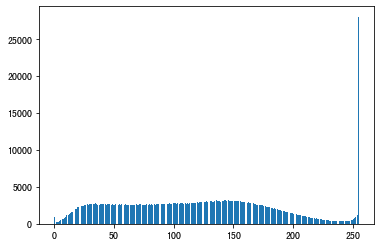

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread("data/02.jpg").astype(np.float)

# Display histogram
plt.hist(img.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.show()

# 2.直方图归一化(Histogram Normalization)

有时候直方图会偏向一边，比如说，数据集中在0处（左侧）的图像全体会偏暗，数据集中在255处（右侧）的图像会偏亮。为了使人能更清楚地看见图片，让直方图归一化、平坦化是十分必要的。这种归一化直方图的操作被称作灰度变换(Grayscale Transformation)。像素点取值范围从$[c,d]$转换到$[a,b]$的过程由下式定义。
$$
x_{out}=
\begin{cases}
a& (\text{if}\quad x_{in}<c) \\\\
\frac{b-a}{d-c}\ (x_{in}-c)+a&(\text{else if}\quad c\leq x_{in}<d) \\\\
b&(\text{else})
\end{cases}
$$

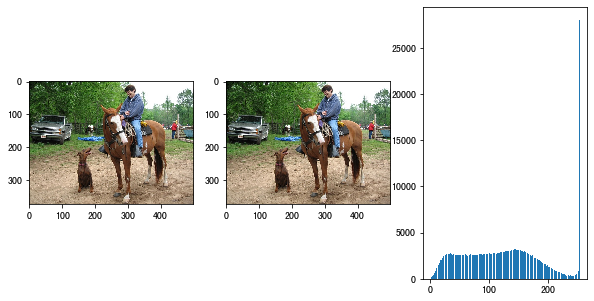

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread("data/02.jpg")
H, W, C = img.shape
a = 0
b = 255
c = img.min()
d = img.max()
out = img.copy()
out = (b-a) / (d - c) * (out - c) + a
out[out < a] = a
out[out > b] = b
out = out.astype(np.uint8)

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
plt.hist(out.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.show()

# 3.直方图操作

让直方图的平均值$m_0=128$，标准差$s_0=52$，可以使得直方图变得平坦。可以使用下式将平均值为$m$标准差为$s$的直方图变成平均值为$m_0$标准差为$s_0$的直方图
$$
\begin{align*}
x_{out}=\frac{s_0}{s}(x_{in}-m)+m_0
\end{align*}
$$

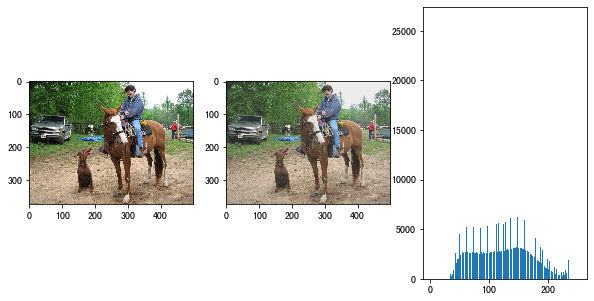

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread("data/02.jpg")
H, W, C = img.shape
m = np.mean(img)
s = np.std(img)
out = img.copy()
out = 52 / s * (out - m) + 128
out[out < 0] = 0
out[out > 255] = 255
out = out.astype(np.uint8)

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
plt.hist(out.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.show()

# 4.直方图均衡化(Histogram Equalization)

直方图均衡化是使直方图变得平坦的操作，并且不需要计算平均值、标准差。均衡化操作由以下式子定义。$S$是总的像素数；$Z_{max}$是像素点的最大取值（在这里是255）；$h(z)$表示取值为$z$的累积分布函数：
$$Z' = \frac{Z_{max}}{S} \  \sum\limits_{i=0}^z\ h(i)$$

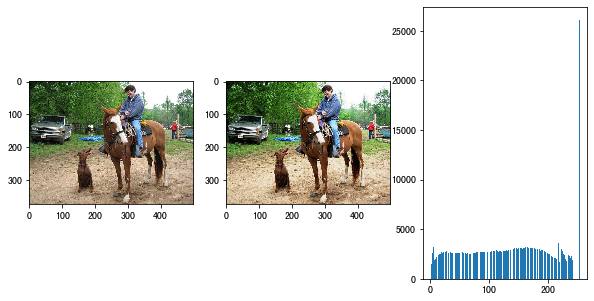

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("data/02.jpg")

# region
H, W, C = img.shape
S = H * W * C * 1
out = img.copy()
sum_h = 0

for i in range(1, 255):
    ind = np.where(img == i)
    sum_h += len(img[ind])
    z_prime = 255 / S * sum_h
    out[ind] = z_prime

out = out.astype(np.uint8)
# endregion

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
plt.hist(out.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.show()

# 5.方向梯度直方图-HOG(Histogram of Oriented Gradients)
HOG是一种表示图像特征量的方法。特征量是表示图像的状态等的向量集合。在深度学习变得流行之前，HOG 经常被用作特征量表达。

通过以下算法获得HOG：
- 图像灰度化之后，在$x$方向和$y$方向上求出亮度的梯度：
$$
\begin{cases}
g_x&=I(x+1,y)-I(x-1,y) & x \text{方向} \\
g_y&=I(x,y+1)-I(x,y-1) & y \text{方向}
\end{cases}
$$
- 从$g_x$和$g_y$确定梯度幅值和梯度方向:
$$
\begin{cases}
mag &= \sqrt{g_x^2+g_y^2} \\
ang &= arctan\frac{g_y}{g_x}
\end{cases}
$$
- 将梯度方向$[0,180]$进行$9$等分量化。也就是说，对于$[0,20]$量化为$index 0$，对于$[20,40]$量化为$index 1$，以此类推
- 将图像划分为$N \times N$个区域(该区域称为 cell)，并作出cell内步骤3得到的index的直方图
- $C \times C$个cell被称为一个block。对每个block内的cell的直方图通过下面的式子进行归一化。由于归一化过程中窗口一次移动一个cell来完成的，因此一个cell会被归一化多次，通常$\epsilon=1$：
$$h(t)=\frac{h(t)}{\sqrt{\sum\ h(t)+\epsilon}}$$

## 5.1.第一步至第三步

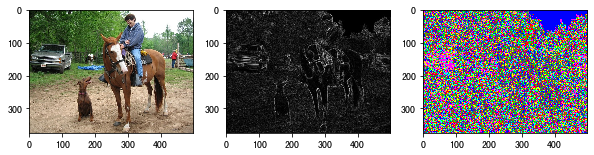

In [7]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su
import numpy as np

def HOG_step1(img):
     # Grayscale
     def BGR2GRAY(img):
          gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
          return gray

     # Magnitude and gradient
     def get_gradXY(gray):
          H, W = gray.shape

          # padding before grad
          gray = np.pad(gray, (1, 1), 'edge')

          # get grad x
          gx = gray[1:H+1, 2:] - gray[1:H+1, :W]
          # get grad y
          gy = gray[2:, 1:W+1] - gray[:H, 1:W+1]
          # replace 0 with 
          gx[gx == 0] = 1e-6

          return gx, gy

     # get magnitude and gradient
     def get_MagGrad(gx, gy):
          # get gradient maginitude
          magnitude = np.sqrt(gx ** 2 + gy ** 2)

          # get gradient angle
          gradient = np.arctan(gy / gx)

          gradient[gradient < 0] = np.pi / 2 + gradient[gradient < 0] + np.pi / 2

          return magnitude, gradient

     # Gradient histogram
     def quantization(gradient):
          # prepare quantization table
          gradient_quantized = np.zeros_like(gradient, dtype=np.int)

          # quantization base
          d = np.pi / 9

          # quantization
          for i in range(9):
               gradient_quantized[np.where((gradient >= d * i) & (gradient <= d * (i + 1)))] = i

          return gradient_quantized

     # 1. BGR -> Gray
     gray = BGR2GRAY(img)

     # 1. Gray -> Gradient x and y
     gx, gy = get_gradXY(gray)

     # 2. get gradient magnitude and angle
     magnitude, gradient = get_MagGrad(gx, gy)

     # 3. Quantization
     gradient_quantized = quantization(gradient)

     return magnitude, gradient_quantized

img = cv2.imread("data/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1) 
plt.imshow(img)

_magnitude,gradient_quantized = HOG_step1(img)
_magnitude = (_magnitude / _magnitude.max() * 255).astype(np.uint8)
plt.subplot(1, 3, 2) 
plt.imshow(cv2.cvtColor(_magnitude, cv2.COLOR_BGR2RGB))

H, W, C = img.shape
out = np.zeros((H, W, 3), dtype=np.uint8)

# define color
C = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255],
     [127, 127, 0], [127, 0, 127], [0, 127, 127]]

# draw color
for i in range(9):
     out[gradient_quantized == i] = C[i]

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

## 5.2.第四步

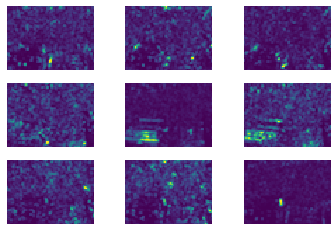

In [3]:
def HOG_step2(img):
    # Grayscale
    def BGR2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        return gray

    # Magnitude and gradient
    def get_gradXY(gray):
        H, W = gray.shape

        # padding before grad
        gray = np.pad(gray, (1, 1), 'edge')

        # get grad x
        gx = gray[1:H+1, 2:] - gray[1:H+1, :W]
        # get grad y
        gy = gray[2:, 1:W+1] - gray[:H, 1:W+1]
        # replace 0 with 
        gx[gx == 0] = 1e-6

        return gx, gy

    # get magnitude and gradient
    def get_MagGrad(gx, gy):
        # get gradient maginitude
        magnitude = np.sqrt(gx ** 2 + gy ** 2)

        # get gradient angle
        gradient = np.arctan(gy / gx)

        gradient[gradient < 0] = np.pi / 2 + gradient[gradient < 0] + np.pi / 2

        return magnitude, gradient

    # Gradient histogram
    def quantization(gradient):
        # prepare quantization table
        gradient_quantized = np.zeros_like(gradient, dtype=np.int)

        # quantization base
        d = np.pi / 9

        # quantization
        for i in range(9):
            gradient_quantized[np.where((gradient >= d * i) & (gradient <= d * (i + 1)))] = i

        return gradient_quantized

        
    # get gradient histogram
    def gradient_histogram(gradient_quantized, magnitude, N=8):
        # get shape
        H, W = magnitude.shape

        # get cell num
        cell_N_H = H // N
        cell_N_W = W // N
        histogram = np.zeros((cell_N_H, cell_N_W, 9), dtype=np.float32)

        # each pixel
        for y in range(cell_N_H):
            for x in range(cell_N_W):
                for j in range(N):
                    for i in range(N):
                        histogram[y, x, gradient_quantized[y * 4 + j, x * 4 + i]] += magnitude[y * 4 + j, x * 4 + i]

        return histogram

    # 1. BGR -> Gray
    gray = BGR2GRAY(img)

    # 1. Gray -> Gradient x and y
    gx, gy = get_gradXY(gray)

    # 2. get gradient magnitude and angle
    magnitude, gradient = get_MagGrad(gx, gy)

    # 3. Quantization
    gradient_quantized = quantization(gradient)

    # 4. Gradient histogram
    histogram = gradient_histogram(gradient_quantized, magnitude)

    return histogram

histogram = HOG_step2(img)
                
# write histogram to file
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(histogram[..., i])
    plt.axis('off')
    plt.xticks(color="None")
    plt.yticks(color="None")

## 5.3.第五步

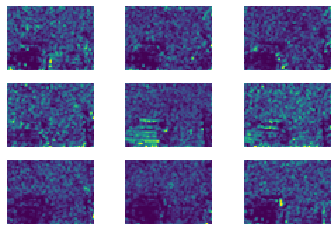

In [4]:
def HOG(img):
    # Grayscale
    def BGR2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        return gray

    # Magnitude and gradient
    def get_gradXY(gray):
        H, W = gray.shape

        # padding before grad
        gray = np.pad(gray, (1, 1), 'edge')

        # get grad x
        gx = gray[1:H+1, 2:] - gray[1:H+1, :W]
        # get grad y
        gy = gray[2:, 1:W+1] - gray[:H, 1:W+1]
        # replace 0 with 
        gx[gx == 0] = 1e-6

        return gx, gy

    # get magnitude and gradient
    def get_MagGrad(gx, gy):
        # get gradient maginitude
        magnitude = np.sqrt(gx ** 2 + gy ** 2)

        # get gradient angle
        gradient = np.arctan(gy / gx)

        gradient[gradient < 0] = np.pi / 2 + gradient[gradient < 0] + np.pi / 2

        return magnitude, gradient

    # Gradient histogram
    def quantization(gradient):
        # prepare quantization table
        gradient_quantized = np.zeros_like(gradient, dtype=np.int)

        # quantization base
        d = np.pi / 9

        # quantization
        for i in range(9):
            gradient_quantized[np.where((gradient >= d * i) & (gradient <= d * (i + 1)))] = i

        return gradient_quantized


    # get gradient histogram
    def gradient_histogram(gradient_quantized, magnitude, N=8):
        # get shape
        H, W = magnitude.shape

        # get cell num
        cell_N_H = H // N
        cell_N_W = W // N
        histogram = np.zeros((cell_N_H, cell_N_W, 9), dtype=np.float32)

        # each pixel
        for y in range(cell_N_H):
            for x in range(cell_N_W):
                for j in range(N):
                    for i in range(N):
                        histogram[y, x, gradient_quantized[y * 4 + j, x * 4 + i]] += magnitude[y * 4 + j, x * 4 + i]

        return histogram

		# histogram normalization
    def normalization(histogram, C=3, epsilon=1):
        cell_N_H, cell_N_W, _ = histogram.shape
        ## each histogram
        for y in range(cell_N_H):
    	    for x in range(cell_N_W):
       	    #for i in range(9):
                histogram[y, x] /= np.sqrt(np.sum(histogram[max(y - 1, 0) : min(y + 2, cell_N_H),
                                                            max(x - 1, 0) : min(x + 2, cell_N_W)] ** 2) + epsilon)

        return histogram

    # 1. BGR -> Gray
    gray = BGR2GRAY(img)

    # 1. Gray -> Gradient x and y
    gx, gy = get_gradXY(gray)

    # 2. get gradient magnitude and angle
    magnitude, gradient = get_MagGrad(gx, gy)

    # 3. Quantization
    gradient_quantized = quantization(gradient)

    # 4. Gradient histogram
    histogram = gradient_histogram(gradient_quantized, magnitude)
    
    # 5. Histogram normalization
    histogram = normalization(histogram)

    return histogram

histogram = HOG(img)
                
# Write result to file
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(histogram[..., i])
    plt.axis('off')
    plt.xticks(color="None")
    plt.yticks(color="None")

## 5.4.可视化特征量

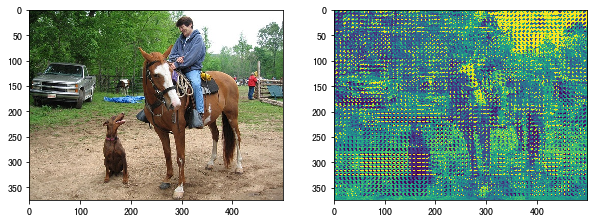

In [5]:
def draw_HOG(img, histogram):
    # Grayscale
    def BGR2GRAY(img):
        gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        return gray

    def draw(gray, histogram, N=8):
        # get shape
        H, W = gray.shape
        cell_N_H, cell_N_W, _ = histogram.shape
        
        ## Draw
        out = gray[1 : H + 1, 1 : W + 1].copy().astype(np.uint8)

        for y in range(cell_N_H):
            for x in range(cell_N_W):
                cx = x * N + N // 2
                cy = y * N + N // 2
                x1 = cx + N // 2 - 1
                y1 = cy
                x2 = cx - N // 2 + 1
                y2 = cy
                
                h = histogram[y, x] / np.sum(histogram[y, x])
                h /= h.max()
        
                for c in range(9):
                    #angle = (20 * c + 10 - 90) / 180. * np.pi
                    # get angle
                    angle = (20 * c + 10) / 180. * np.pi
                    rx = int(np.sin(angle) * (x1 - cx) + np.cos(angle) * (y1 - cy) + cx)
                    ry = int(np.cos(angle) * (x1 - cx) - np.cos(angle) * (y1 - cy) + cy)
                    lx = int(np.sin(angle) * (x2 - cx) + np.cos(angle) * (y2 - cy) + cx)
                    ly = int(np.cos(angle) * (x2 - cx) - np.cos(angle) * (y2 - cy) + cy)

                    # color is HOG value
                    c = int(255. * h[c])

                    # draw line
                    cv2.line(out, (lx, ly), (rx, ry), (c, c, c), thickness=1)

        return out
    

    # get gray
    gray = BGR2GRAY(img)

    # draw HOG
    out = draw(gray, histogram)

    return out

out = draw_HOG(img, histogram)
plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(img)

plt.subplot(1, 2, 2) 
plt.imshow(out)